# Static link prediction
In this notebook, we will apply models from the PyKEEN package to generate link predictions on the entire graph as a static object.

In [1]:
import networkx as nx
from pykeen.triples import TriplesFactory
from pykeen.pipeline import pipeline
from pykeen.constants import PYKEEN_CHECKPOINTS
import torch
from pykeen.models import RESCAL
from itertools import combinations
from tqdm import tqdm
import json
import pandas as pd
from collections import Counter, defaultdict
from scipy.stats import randint
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_auc_score, RocCurveDisplay, auc, roc_curve
import pickle
from pykeen import predict
from random import choice
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
import numpy as np
from itertools import cycle
from ast import literal_eval

2024-06-04 23:35:10.166370: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Read in the PyKEEN tensors
Training a PyKEEN model on a graph this size takes a while, so we submitted it as a job. Here, we'll read in the final checkopint to re-instantiate the trained model, and use it to build our prediction mechanism.

### Drought + DT

In [2]:
checkpoint = torch.load(PYKEEN_CHECKPOINTS.joinpath('dt_rescal_cleaned.pt'), map_location=torch.device('cpu'))

We need to use the same train/test split when re-instantiating the model. The splitting printed a random seed to our output file which we can use here:

```
using automatically assigned random_state=3199520993
```

In [3]:
def get_predicate(row):
    if row.is_drought:
        if row.is_desiccation:
            return 'both'
        else:
            return 'drought'
    else:
        if row.is_desiccation:
            return 'desiccation'

In [4]:
graph = nx.read_graphml('../data/kg/all_drought_dt_co_occurrence_graph_03Jun2024.graphml')
edgelist = nx.to_pandas_edgelist(graph)
edgelist['predicate'] = edgelist.apply(get_predicate, axis=1)
triples = edgelist[['source', 'predicate', 'target']].to_numpy()
print(f'Snapshot of triples: {triples[:5]}')

Snapshot of triples: [['peg-induced drought tolerance' 'drought' 'sesame']
 ['peg-induced drought tolerance' 'drought' 'sesame drought tolerance']
 ['peg-induced drought tolerance' 'drought' 'otsa']
 ['peg-induced drought tolerance' 'drought' 'p5cr']
 ['peg-induced drought tolerance' 'drought' 'glgx']]


In [5]:
tf = TriplesFactory.from_labeled_triples(triples,
                                         create_inverse_triples=True,
                                         entity_to_id=checkpoint['entity_to_id_dict'],
                                         relation_to_id=checkpoint['relation_to_id_dict'])
training, validation, testing = tf.split([0.8, 0.1, 0.1], random_state=3199520993)

There was also a random seed printed when instantiating the model:

```
No random seed is specified. Setting to 1687969045.
```

In [6]:
my_model = RESCAL(triples_factory=training, random_seed=1687969045)
my_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

### Genophenoenvo
```
using automatically assigned random_state=1302255564
No random seed is specified. Setting to 1545290840
```

In [2]:
gpe_graph = nx.read_graphml('../data/genophenoenvo/genophenoenvo_from_edge_and_nodelist.graphml')
gpe_edgelist = nx.to_pandas_edgelist(gpe_graph)
gpe_triples = gpe_edgelist[['source', 'predicate', 'target']].to_numpy()
print(f'Snapshot of triples: {gpe_triples[:5]}')

Snapshot of triples: [['NCBITaxon:4577' 'biolink:has_phenotype' 'TO:0000207']
 ['NCBITaxon:4577' 'biolink:has_phenotype' 'TO:0000919']
 ['NCBITaxon:4577' 'biolink:has_phenotype' 'TO:0000396']
 ['NCBITaxon:4577' 'biolink:has_phenotype' 'TO:0000352']
 ['NCBITaxon:4577' 'biolink:has_phenotype' 'TO:0000478']]


In [3]:
gpe_checkpoint = torch.load(PYKEEN_CHECKPOINTS.joinpath('gpe_rescal_take_2.pt'), map_location=torch.device('cpu'))

In [5]:
gpe_tf = TriplesFactory.from_labeled_triples(gpe_triples,
                                         create_inverse_triples=True,
                                         entity_to_id=gpe_checkpoint['entity_to_id_dict'],
                                         relation_to_id=gpe_checkpoint['relation_to_id_dict'])
gpe_training, gpe_validation, gpe_testing = gpe_tf.split([0.8, 0.1, 0.1], random_state=1302255564)

In [6]:
gpe_model = RESCAL(triples_factory=gpe_training, random_seed=1545290840)
gpe_model.load_state_dict(gpe_checkpoint['model_state_dict'])

<All keys matched successfully>

## Use embedding representations to make predictions
Rather than use the built-in prediction capabilities of the embedding model (which I have previously found to be terrible), I would like to try taking the embeddings and using them in a RF model to start. The idea is to use the node embeddings as features, and try to predict new edges.

### Format training and testing data
Fortunately, we've already got a data split for the positive triples, and we can just artificially construct negative instances to match the number we have for the train and test sets. We'll start out with 5,000 of each class; if the model performs poorly, we can add more training data.

#### Get pairs for each class

#### Drought + DT

In [19]:
train_trips_semantic = training.triples
test_trips_semantic = testing.triples

Reconstructing all label-based triples. This is expensive and rarely needed.
Reconstructing all label-based triples. This is expensive and rarely needed.


In [20]:
print(f'There are {len(train_trips_semantic)} training triples and {len(test_trips_semantic)} testing triples.')

There are 1031199 training triples and 128900 testing triples.


In [21]:
train_ent_types = Counter([t[1] for t in train_trips_semantic])
train_ent_types

Counter({'drought': 953272, 'desiccation': 59990, 'both': 17937})

In [22]:
test_ent_types = Counter([t[1] for t in test_trips_semantic])
test_ent_types

Counter({'drought': 119862, 'desiccation': 6952, 'both': 2086})

In [23]:
def get_class_pairs(semantic_trips, num_inst=2000):
    """
    Get triples for each of 'desiccation', 'drought', 'both', 'negative'.

    parameters:
        semantic_trips, list of list: triples
        num_inst, int: number of instances to get for each class.

    returns:
        data, dict: keys are class names, values are pairs for the class.
    """
    # Get positive instances
    data = defaultdict(list)
    for trip in semantic_trips:
        trip_type = trip[1]
        if len(data[trip_type]) < num_inst:
            data[trip_type].append((trip[0], trip[2]))
        else:
            if sum([len(v) for v in data.values()]) == num_inst*len(data.keys()):
                break
    
    # Generate negative instances
    negs = []
    all_ents = set([trip[0] for trip in semantic_trips] + [trip[2] for trip in semantic_trips])
    for pair in combinations(all_ents, 2):
        not_pos = True
        for r_type, pairs in data.items():
            if pair in pairs:
                not_pos = False
            elif (pair[1], pair[0]) in pairs:
                not_pos = False
        if not_pos:
            negs.append(pair)
        if len(negs) == num_inst:
            break
    data['negative'] = negs
    
    return data

In [24]:
train_pairs = get_class_pairs(train_trips_semantic, num_inst=2000)

In [25]:
test_pairs = get_class_pairs(test_trips_semantic, num_inst=1000)

#### Genophenoenvo

In [7]:
gpe_train_trips_semantic = gpe_training.triples
gpe_test_trips_semantic = gpe_testing.triples

Reconstructing all label-based triples. This is expensive and rarely needed.
Reconstructing all label-based triples. This is expensive and rarely needed.


In [8]:
print(f'There are {len(gpe_train_trips_semantic)} training triples and {len(gpe_test_trips_semantic)} testing triples.')

There are 4255085 training triples and 531886 testing triples.


In [9]:
gpe_train_ent_types = Counter([t[1] for t in gpe_train_trips_semantic])
gpe_train_ent_types

Counter({'biolink:has_phenotype': 2009560,
         'biolink:expressed_in': 1104891,
         'biolink:in_taxon': 303428,
         'biolink:enables': 278748,
         'biolink:regulates': 231091,
         'biolink:active_in': 157923,
         'biolink:subclass_of': 84798,
         'biolink:orthologous_to': 67437,
         'biolink:part_of': 7090,
         'biolink:negatively_regulates': 2763,
         'biolink:positively_regulates': 2394,
         'biolink:increases_expression_of': 2118,
         'biolink:decreases_expression_of': 1856,
         'biolink:has_attribute': 236,
         'biolink:related_to': 174,
         'biolink:subPropertyOf': 132,
         'biolink:develops_from': 130,
         'biolink:has_part': 118,
         'biolink:interacts_with': 87,
         'biolink:inverseOf': 31,
         'biolink:participates_in': 24,
         'biolink:preceded_by': 17,
         'biolink:has_participant': 16,
         'biolink:coexists_with': 12,
         'biolink:located_in': 4,
         

In [10]:
gpe_test_ent_types = Counter([t[1] for t in gpe_test_trips_semantic])
gpe_test_ent_types

Counter({'biolink:has_phenotype': 275837,
         'biolink:expressed_in': 152012,
         'biolink:regulates': 29664,
         'biolink:enables': 27348,
         'biolink:active_in': 19554,
         'biolink:in_taxon': 18491,
         'biolink:subclass_of': 6070,
         'biolink:orthologous_to': 2223,
         'biolink:part_of': 423,
         'biolink:positively_regulates': 184,
         'biolink:has_attribute': 21,
         'biolink:increases_expression_of': 10,
         'biolink:decreases_expression_of': 9,
         'biolink:interacts_with': 9,
         'biolink:subPropertyOf': 7,
         'biolink:has_part': 6,
         'biolink:related_to': 5,
         'biolink:participates_in': 3,
         'biolink:has_participant': 3,
         'biolink:develops_from': 3,
         'biolink:preceded_by': 1,
         'biolink:precedes': 1,
         'biolink:negatively_regulates': 1,
         'biolink:coexists_with': 1})

#### Get features for each pair
Now we need to wrangle the embeddings for each pair. we're going to make 100 features, one for each column of the embedding for each node.

In [26]:
node_reps = my_model.entity_representations[0]()

In [27]:
ent_map = checkpoint['entity_to_id_dict']

In [17]:
label_map = {
    'desiccation': 1,
    'drought': 2,
    'both': 3,
    'negative': 0
}

In [29]:
all_train_feat_dfs = []
for lab, pair_list in train_pairs.items():
    class_feats = {}
    for pair in pair_list:
        feats = node_reps[ent_map[pair[0]]].tolist()
        feats.extend(node_reps[ent_map[pair[1]]].tolist())
        class_feats[pair] = feats
    class_df = pd.DataFrame.from_dict(class_feats, orient='index')
    class_df['label'] = label_map[lab]
    all_train_feat_dfs.append(class_df)
train_df = pd.concat(all_train_feat_dfs).sample(frac=1) # Shuffle the data
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,label
"(all4052, all4477)",0.001419,-2.130843e-03,1.024443e-03,-1.559786e-03,-0.003593,-2.568180e-03,2.926126e-03,-6.287001e-03,0.006255,0.001031,...,-0.004623,-0.004326,0.004348,-0.004640,0.005677,-0.005106,-0.004622,-0.004500,-0.004696,1
"(alfalfa, alfalfa pastures)",-0.000251,-2.886081e-04,-4.827163e-04,1.994908e-04,-0.000014,-5.719028e-09,6.537642e-09,2.886407e-09,0.000150,0.001235,...,0.018649,-0.010705,0.008162,0.013279,0.000136,0.012928,0.013255,0.013146,-0.007766,3
"(1 -kestose, -kestose)",0.001130,-2.990063e-03,5.811866e-03,3.060086e-03,0.002420,4.456422e-03,-3.244529e-03,-1.938339e-03,-0.002879,-0.007100,...,-0.006577,0.009521,0.009604,-0.002438,0.009321,0.008316,0.009588,-0.010011,0.007370,2
"(aba, drought-responsive cis-element)",0.000177,-3.255699e-08,2.704524e-07,1.725043e-07,-0.000006,3.342127e-08,-9.461079e-04,-3.869868e-07,0.000027,-0.001527,...,-0.010375,0.010232,0.011978,0.010308,-0.010313,-0.012531,0.012357,0.010144,-0.013073,3
"(australian northern savannah, cyanobacterial crusts)",0.017236,-3.015362e-03,-1.205639e-02,1.719053e-02,0.019353,-1.746927e-02,-1.712730e-02,1.812002e-02,0.017914,-0.020456,...,0.019603,0.016363,0.005355,0.005580,0.014346,-0.000250,0.013808,0.005305,-0.000268,3


In [30]:
all_test_feat_dfs = []
for lab, pair_list in test_pairs.items():
    class_feats = {}
    for pair in pair_list:
        feats = node_reps[ent_map[pair[0]]].tolist()
        feats.extend(node_reps[ent_map[pair[1]]].tolist())
        class_feats[pair] = feats
    class_df = pd.DataFrame.from_dict(class_feats, orient='index')
    class_df['label'] = label_map[lab]
    all_test_feat_dfs.append(class_df)
test_df = pd.concat(all_test_feat_dfs).sample(frac=1) # Shuffle the data
test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,label
"(soybean, gmcam1)",2.927227e-08,2.312194e-08,-0.000004,-0.000014,-4.584907e-07,5.141693e-09,-4.669066e-09,-4.659951e-10,-1.336745e-07,1.008057e-05,...,0.020855,0.012851,-0.020776,0.020818,0.020872,0.015361,-0.017933,-0.011432,-0.020847,2
"(a subgenome, lupine seedlings)",2.187721e-03,-1.705986e-03,0.001874,-0.001869,1.122900e-03,1.801459e-03,-2.315101e-03,-4.034842e-03,1.962616e-03,2.264464e-03,...,0.019736,0.015639,-0.019236,-0.015208,-0.005364,-0.000070,-0.017089,0.019151,-0.014304,0
"(calreticulin, arabidopsis calreticulin mutants)",-1.804768e-06,-2.303547e-05,-0.002885,-0.000038,-2.183999e-07,3.467447e-06,-1.749828e-03,3.275455e-05,3.085433e-07,-7.602000e-07,...,0.019404,0.019404,-0.018913,-0.019363,-0.019396,-0.018385,-0.019403,0.001608,0.019408,2
"(emb266, lec2 - 1)",-3.938132e-03,1.228575e-02,0.000812,-0.000013,1.952403e-03,3.110943e-03,-9.503278e-04,-5.607460e-05,-8.878234e-04,2.927759e-03,...,0.012785,-0.015885,0.002436,0.012814,-0.011812,-0.002421,-0.013448,0.014072,-0.014581,1
"(sphagnum denticulatum brid, sphagnum denticulatum brid .)",1.437014e-02,-1.430955e-02,-0.014370,0.014132,1.342223e-02,-3.611036e-03,1.440884e-02,-1.422003e-02,-1.434164e-02,-1.437474e-02,...,0.000504,0.014360,0.016046,0.000042,-0.004539,0.014769,0.000998,-0.005615,-0.000071,3


In [31]:
print(f'There are {len(train_df)} training instances, and {len(test_df)} test instances.')

There are 8000 training instances, and 4000 test instances.


Save these so our results are reproducible:

In [32]:
train_df.to_csv('../data/ml_inputs/dt_co_occurrence_cleaned_training_pairs_2000_03Jun2024.csv')
test_df.to_csv('../data/ml_inputs/dt_co_occurrence_cleaned_testing_pairs_1000_03Jun2024.csv')

### Define and train the model

In [33]:
X_train = train_df.drop(columns='label').to_numpy()
y_train = train_df['label'].to_numpy()

In [34]:
params_to_test = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(1,50),
    'criterion': ['gini', 'entropy', 'log_loss']
}

rf = RandomForestClassifier(verbose=1)
rand_search = RandomizedSearchCV(rf,
                                param_distributions=params_to_test,
                                cv=5,
                                verbose=1)

In [35]:
rand_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 384 out of 384 | elapsed:   55.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 384 out of 384 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 384 out of 384 | elapsed:   54.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 384 out of 384 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 384 out of 384 | elapsed:   54.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 384 out of 384 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 263 out of 263 | elapsed:   13.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 263 out of 263 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 263 out of 263 | elapsed:   13.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 263 out of 263 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 263 out of 263 | elapsed:   13.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 263 out of 263 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 465 out of 465 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Us

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(verbose=1),
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x2ace00e8d6c0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x2acdfa530be0>},
                   verbose=1)

In [45]:
best_rf = rand_search.best_estimator_
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'criterion': 'entropy', 'max_depth': 47, 'n_estimators': 355}


In [46]:
# Save the model as a pickle
with open('../data/ml_outputs/co_occurrence_RF_model_03Jun2024_2000_per_class_CLEANED.pk', 'wb') as f:
    pickle.dump(best_rf, f)

### Evaluate the model

In [14]:
# Load the model back in 
with open('../data/ml_outputs/co_occurrence_RF_model_03Jun2024_2000_per_class_CLEANED.pk', 'rb') as f:
    best_rf = pickle.load(f)

In [19]:
train_df = pd.read_csv('../data/ml_inputs/dt_co_occurrence_cleaned_training_pairs_2000_03Jun2024.csv', index_col=0)
test_df = pd.read_csv('../data/ml_inputs/dt_co_occurrence_cleaned_testing_pairs_1000_03Jun2024.csv', index_col=0)

In [20]:
X_train = train_df.drop(columns='label').to_numpy()
y_train = train_df['label'].to_numpy()

In [21]:
X_test = test_df.drop(columns='label').to_numpy()
y_test = test_df['label'].to_numpy()

In [58]:
y_pred = best_rf.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 355 out of 355 | elapsed:    0.3s finished


In [59]:
cm = confusion_matrix(y_test, y_pred)

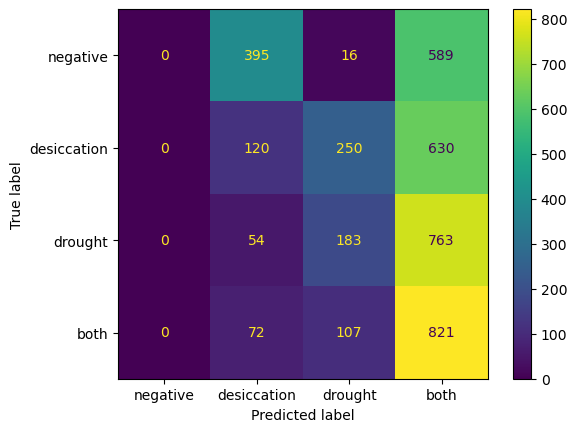

In [60]:
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'desiccation', 'drought', 'both']).plot();

In [54]:
f1 = f1_score(y_pred, y_test, average='macro')
print(f'The 2,000 sample model achieved an F1 of {f1:.2f}.')

The 2,000 sample model achieved an F1 of 0.20.


In [18]:
aucroc_score = roc_auc_score(y_test, best_rf.predict_proba(X_test), average='macro', multi_class='ovr')
print(f'The 2,000 sample model achieved an AUROC of {aucroc_score:.2f}.')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


The 2,000 sample model achieved an AUROC of 0.54.


[Parallel(n_jobs=1)]: Done 355 out of 355 | elapsed:    0.3s finished


We also want to visualize the curve that was used to calculate the AUROC. In a multi-class scenario it's a little more complicated, as the overall score is a composite of either One-vs-Rest, where each class is compared against all others, or One-vs-One, which each pair of classes is compared. We'll follow the tutorial from sklearn [here](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#roc-curve-using-the-ovr-macro-average) to plot the macro averaged curves for One-vs-Rest, which is what was used to calculate the score above.

In [28]:
y_score = best_rf.predict_proba(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 355 out of 355 | elapsed:    0.3s finished


In [32]:
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

(4000, 4)

In [46]:
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(label_map)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.54


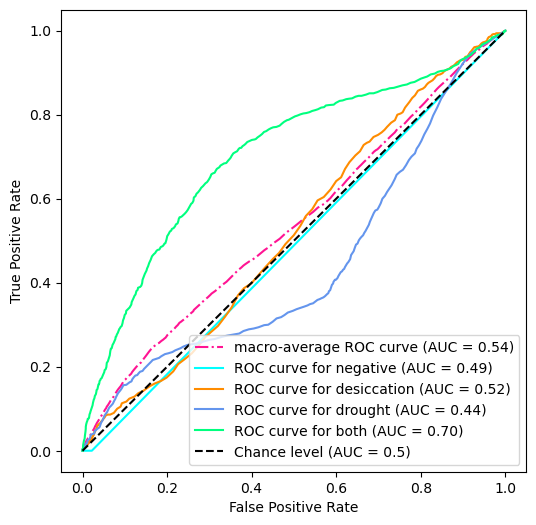

In [54]:
reverse_label_map = {v: k for k, v in label_map.items()}
fig, ax = plt.subplots(figsize=(6, 6))

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="deeppink",
    linestyle="dashdot",
)

colors = cycle(["aqua", "darkorange", "cornflowerblue", "springgreen"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {reverse_label_map[class_id]}",
        color=color,
        ax=ax,
        plot_chance_level=(class_id == 3),
    )

_ = ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
#     title="Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass",
)

What happens to prediction if we include node labels as features in addition to the 

## Using PyKEEN built-in prediction
It looks like a simple RF model with just the node embeddings isn't going to cut it for prediction. Let's try the built-in PyKEEN prediction methods and see if we can do any better.

The tricky thing about link prediction is choosing *what to predict*. In the above RF case, we asked about a (relatively) random set of 8,000 triples in the test set. In PyKEEN, while there is an option to `predict_all` triples, it's very computationally expensive because it involves calculating the score for every single possible triple. Therefore, we can do a few different things, like, given a head entity, predict the likelihood of anything being a tail entity, or get scores for a list of triples. For the sake of being able to compare these results with the RF model above, let's ask it to predict the types of the triples in the same test set. Since it wants a predicate for a given triple, we will choose predicates randomly from the three options for the negative samples.

In [22]:
# Restore the ones from the saved training data
train_pairs = {lab: [literal_eval(tup) for tup in train_df[train_df['label'] == label_map[lab]].index.tolist()] for lab in label_map.keys()}
test_pairs = {lab: [literal_eval(tup) for tup in test_df[test_df['label'] == label_map[lab]].index.tolist()] for lab in label_map.keys()}

test_trips = []
negative_trips = []
for lab, pairs in test_pairs.items():
    if lab == 'negative':
        predicate = choice(['desiccation', 'drought', 'both'])
        negative_trips.extend([(pair[0], predicate, pair[1]) for pair in pairs])
    else:
        predicate = lab
    test_trips.extend([(pair[0], predicate, pair[1]) for pair in pairs])

In [23]:
scores = predict.predict_triples(
    model=my_model,
    triples=test_trips,
    triples_factory=testing,
)

Using maximize_memory_utilization on non-CUDA tensors. This may lead to undocumented crashes due to CPU OOM killer.
/mnt/home/lotrecks/anaconda3/envs/graphs/lib/python3.10/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [24]:
score_df = scores.process(testing).df

In [25]:
score_df = score_df.sort_values(by='score', ascending=False).reset_index(drop=True)
score_df.head()

,head_id,head_label,relation_id,relation_label,tail_id,tail_label,score
0,158625,malus xdomestica ' gala,0,both,110261,gala-4x,0.000003
1,257205,stratosphere,1,desiccation,159926,marsbox,0.000003
2,24208,apy(2)sk(2 ) and apsk(3 ) transformation,0,both,225854,recombinant apy(2)sk(2 ),0.000002
3,132043,hypobaria,0,both,132045,hypobaric biology,0.000002
4,95163,ellagic acid derivatives,1,desiccation,267887,terminalia chebula retz,0.000002


Add back a column to check which triples were supposed to be negative:

In [26]:
def is_negative(row):
    if (row.head_label, row.relation_label, row.tail_label) in negative_trips:
        return True
    else:
        return False

In [27]:
score_df['is_negative'] = score_df.apply(is_negative, axis=1)

We want to see where the negative triples rank in the scoring. We would like them to be at the bottom if the model is performing well:

In [28]:
neg_ranks = score_df[score_df['is_negative']].index.tolist()

In [29]:
pos_ranks = score_df[~score_df['is_negative']].index.tolist()

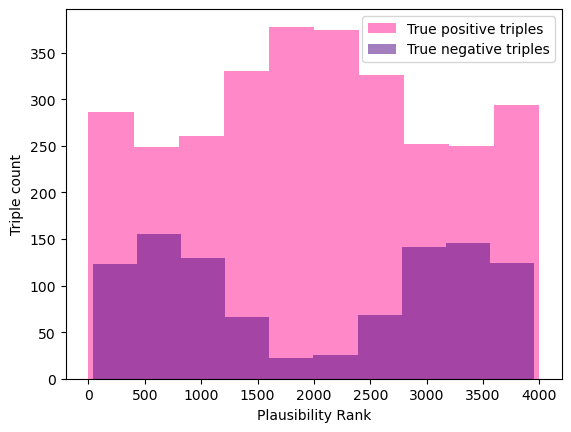

In [30]:
fig, ax = plt.subplots()

ax.hist(pos_ranks, color='deeppink', alpha=0.5, label='True positive triples')
ax.hist(neg_ranks, color='indigo', alpha=0.5, label='True negative triples')
ax.set_xlabel('Plausibility Rank')
ax.set_ylabel('Triple count')
ax.legend()

Now let's plot the scores:

In [31]:
neg_scores = score_df[score_df['is_negative']].score.tolist()
pos_scores = score_df[~score_df['is_negative']].score.tolist()

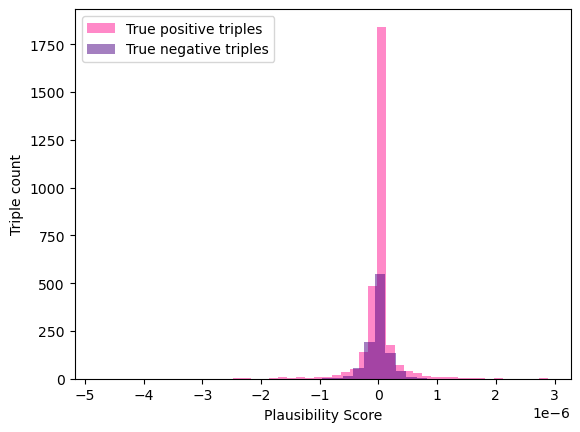

In [34]:
fig, ax = plt.subplots()

ax.hist(pos_scores, bins=50, color='deeppink', alpha=0.5, label='True positive triples')
ax.hist(neg_scores, color='indigo', alpha=0.5, label='True negative triples')
ax.set_xlabel('Plausibility Score')
ax.set_ylabel('Triple count')
ax.legend()

Unfortunately, both kinds of triples are at both ends of the ranking spectrum. However, we see that negative and positive triples display somewhat different patterns of rank distribution. Whereas positive triples are most often scoring in the middle of the pack, negative triples either score on the high-ranked end or the low-ranked end, but not so much in the middle. This is likely an artefact of there being many more positive triples with scores near 0 than negative triples; they tend to "crowd out" the negative triples in the center of the ranking.

### Generating comparable performance metrics for PyKEEN model
We would like to generate an AUROC/PRC curve so that we can compare the rank-based prediction to that of the RF model and the STHN TLP model. The RESCAL authors state that "link prediction can be done by comparing \[the plausibility score\] to some given threshold θ". Therefore, we will generate a set of thresholds and build an AUROC curve, from which we can choose the best threshold and then calculate an F1 score.

Note that this is somewhat different from the RF model in that it's not a multiclass problem: we provided the relation label, and the model is tasked with deciding if the relation is true or not, which makes this a binary problem. We therefore might expect better performance from this model, as it should be easier to decide true vs. false than to have to choose both true vs. false as well as which label it is. This means that we can't directly compare the AUROC's for the two models -- however, it will be helpful to see how this model performs.

In [83]:
pykeen_test = [0 if n else 1 for n in score_df.is_negative]

In [86]:
fpr, tpr, thresholds = roc_curve(pykeen_test, score_df.score)
pykeen_auc = auc(fpr, tpr)
print(f'The PyKEEN RESCAL model has an AUROC of {pykeen_auc:.2f}')

The PyKEEN RESCAL model has an AUROC of 0.52


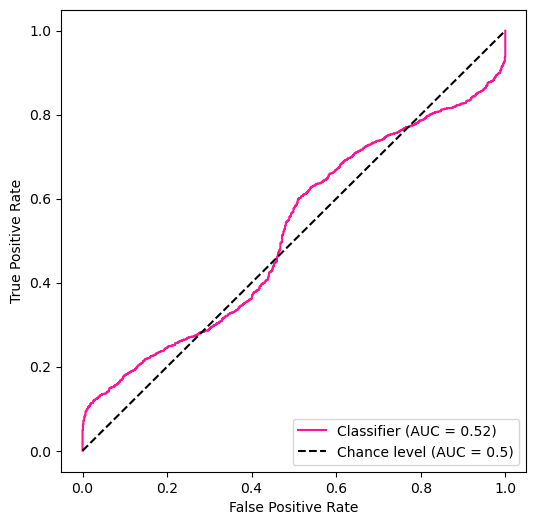

In [88]:
fig, ax = plt.subplots(figsize=(6, 6))

RocCurveDisplay.from_predictions(
    pykeen_test,
    score_df.score,
    color='deeppink',
    ax=ax,
    plot_chance_level=True,
)
_ = ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)

### Predicting top 100 triples
If we were to use this method to look for the most probable new connections in the graph without having a previous hypothesis about what kinds of triples we think are most likely to be interesting, we would use `predict_all`. We can just store the top 100 to save on memory, but it doesn't change how many scores have to be calculated. This may prove too computationally challenging, but I would like to try it:

#### Drought + DT

In [7]:
all_scores = predict.predict_all(
    model=my_model,
    k=100
)

predict is an expensive operation, involving 268,971,381,552 score evaluations.
/mnt/home/lotrecks/anaconda3/envs/graphs/lib/python3.10/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


scoring:   0%|          | 0.00/898k [00:00<?, ?batch/s]

In [11]:
top_100_dt = all_scores.process(tf).df
top_100_dt.head()

,head_id,head_label,relation_id,relation_label,tail_id,tail_label,score
0,69982,common scab disease,0,both,34292,b. lactucae,0.000037
1,106967,frankliniella occidentalis pergande,0,both,176129,nbs-lrr disease resistance genes,0.000036
2,258095,sub-saharan african,0,both,252545,soybean cyp707a gene family,0.000035
3,79880,dabz-f1,0,both,252545,soybean cyp707a gene family,0.000034
4,28583,ascophyllum nodosum extracts,0,both,253661,sphagnum peat mesocosms,0.000034


In [12]:
# Save out
top_100_dt.to_csv('../data/ml_outputs/RESCAL_rank_based_top_100_triples_from_predict_all.csv', index=False)

In [37]:
top_100_dt = pd.read_csv('../data/ml_outputs/RESCAL_rank_based_top_100_triples_from_predict_all.csv')

Text(0.5, 0.01, 'Score')

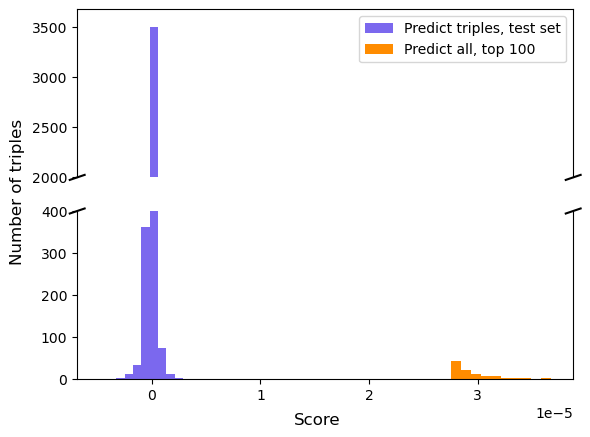

In [38]:
# Code from https://matplotlib.org/2.0.2/examples/pylab_examples/broken_axis.html
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

_ = ax1.hist(score_df.score, color='mediumslateblue', label='Predict triples, test set')
_ = ax1.hist(top_100_dt.score, color='darkorange', label='Predict all, top 100')
_ = ax2.hist(score_df.score, color='mediumslateblue', label='Predict triples, test set')
_ = ax2.hist(top_100_dt.score, color='darkorange', label='Predict all, top 100')

# Get max y-value
maxy = ax1.get_ylim()[1]
basemax = plt.yticks()[0][-3]

# Set the y limits
ax1.set_ylim(basemax, maxy)
ax2.set_ylim(0, 400) # Got by trial end error

# Finish formatting
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False, top=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

# Add the cut diagonals
d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

_ = ax1.legend(loc='upper right')
fig.supylabel('Number of triples')
fig.supxlabel('Score')

If we were to perform this on the graph to try and find new hypotheses, these are the best predictions we could expect. We can already see that most of these are either trivial or unrelated to desiccation. We'll do some literature searching to characterize the top 10 most likely triples.

In [43]:
top_10 = top_100_dt[['head_label', 'relation_label', 'tail_label']].copy()
top_10.head(10)

,head_label,relation_label,tail_label
0,common scab disease,both,b. lactucae
1,frankliniella occidentalis pergande,both,nbs-lrr disease resistance genes
2,sub-saharan african,both,soybean cyp707a gene family
3,dabz-f1,both,soybean cyp707a gene family
4,ascophyllum nodosum extracts,both,sphagnum peat mesocosms
5,q. maxima,both,catalase and gr activities
6,medium salt,both,peanut leaves or roots
7,timber revenue,both,brazilian eucalypt plantations
8,hex aquifolium,both,embolism recovery
9,ggcms,both,methyltransferase-2 domains


Since these are labeled as both, let's check whether they originally had a drought label or not:

In [44]:
pair_triples = {(t[0], t[2]): t[1] for t in triples}

In [45]:
def get_original_connection(row, all_trips):
    pair = (row.head_label, row.tail_label)
    try:
        lab = all_trips[pair]
    except KeyError:
        lab = 'negative'
    return lab

In [46]:
top_100_dt['original_connection'] = top_100_dt.apply(get_original_connection, axis=1, all_trips=pair_triples)

Check the number of each original connection type we have in the top 10:

In [49]:
top_100_dt.groupby(by='original_connection').count()

,head_id,head_label,relation_id,relation_label,tail_id,tail_label,score
original_connection,,,,,,,
negative,100,100,100,100,100,100,100


Now check what types they were predicted as:

In [50]:
top_100_dt.groupby(by='relation_label').count()

,head_id,head_label,relation_id,tail_id,tail_label,score,original_connection
relation_label,,,,,,,
both,100,100,100,100,100,100,100


In [47]:
top_10['original_connection'] = top_10.apply(get_original_connection, axis=1, all_trips=pair_triples)

In [48]:
top_10.head(10)

,head_label,relation_label,tail_label,original_connection
0,common scab disease,both,b. lactucae,negative
1,frankliniella occidentalis pergande,both,nbs-lrr disease resistance genes,negative
2,sub-saharan african,both,soybean cyp707a gene family,negative
3,dabz-f1,both,soybean cyp707a gene family,negative
4,ascophyllum nodosum extracts,both,sphagnum peat mesocosms,negative
5,q. maxima,both,catalase and gr activities,negative
6,medium salt,both,peanut leaves or roots,negative
7,timber revenue,both,brazilian eucalypt plantations,negative
8,hex aquifolium,both,embolism recovery,negative
9,ggcms,both,methyltransferase-2 domains,negative


Investigate origin of weird entities:

In [51]:
nx.get_node_attributes(graph, 'uids_of_origin')['q. maxima']

'WOS:000527202100030'

In [52]:
nx.get_node_attributes(graph, 'uids_of_origin')['hex aquifolium']

'WOS:000302592900009'

In [53]:
nx.get_node_attributes(graph, 'uids_of_origin')['ggcms']

'WOS:000770435100001'

#### Genophenoenvo